# A simple Multi-Layer Perceptron (MLP) model for temperature prediction
Luke Madaus -- 14 April 2025

This notebook shows a simple multi-layer perceptron network being used to predict the next day's maximum temperature based on the previous several days.  It shows the following:

- Pulling actual observed weather data for a weather station (Madison Dane County Airport)
- Normalizing that data using an annual cycle
- Setting up the training, validation and testing data using PyTorch tools
- Building a multi-layer perceptron model architecture using PyTorch
- Setting up and executing a training loop
- Evaluating the model against validation and test datasets
- Saving and loading a trained model
- Using the model to make a single prediction

The libraries needed are below.  This should be able to run reasonably on a modern laptop with only CPUs (no GPU necessary).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from datetime import datetime, timedelta


## Getting data

We are going to use historical daily weather observations from the Madison Dane County Airport.  We can get a live copy of that data directly from the NOAA/NCEI web page.

In [2]:
# Get a time series of historical daily weather data from Madison
# Use the GHCN dataset
# Find Madison in the inventory
ghcn_inventory = pd.read_fwf('https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt',colspecs='infer',
                            names=['ID','lat','lon','elevation','station_name','state','gsn/hcn','wban'], index_col='ID')
ghcn_inventory

,lat,lon,elevation,station_name,state,gsn/hcn,wban
ID,,,,,,,
ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN
ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,NaN,NaN,NaN
AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,NaN,GSN,41196.0
AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,NaN,NaN,41194.0
AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,NaN,NaN,41217.0
...,...,...,...,...,...,...,...
ZI000067969,21.0500,29.3670,861.0,WEST NICHOLSON,NaN,NaN,67969.0
ZI000067975,20.0670,30.8670,1095.0,MASVINGO,NaN,NaN,67975.0
ZI000067977,21.0170,31.5830,430.0,BUFFALO RANGE,NaN,NaN,67977.0


In [3]:
msn_id = ghcn_inventory[ghcn_inventory['station_name'].str.contains('MADISON DANE CO')]
msn_id

,lat,lon,elevation,station_name,state,gsn/hcn,wban
ID,,,,,,,
USW00014837,43.1406,-89.3453,261.8,MADISON DANE CO RGNL AP,NaN,NaN,72641.0


In [4]:
# Now access the daily timeseries
obdf = pd.read_csv(f'https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_station/{msn_id.index[0]}.csv.gz',
                  names=['ID','DATE','ELEMENT','VALUE','M-FLAG','Q-FLAG','S-FLAG','TIME'],
                  parse_dates=['DATE'], index_col='DATE')
obdf

/var/folders/sp/45zdxb793cnb_rj5n9732f400000gn/T/ipykernel_99403/824343343.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  obdf = pd.read_csv(f'https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_station/{msn_id.index[0]}.csv.gz',


,ID,ELEMENT,VALUE,M-FLAG,Q-FLAG,S-FLAG,TIME
DATE,,,,,,,
1939-10-01,USW00014837,TMAX,194,NaN,NaN,X,NaN
1939-10-02,USW00014837,TMAX,211,NaN,NaN,X,NaN
1939-10-03,USW00014837,TMAX,233,NaN,NaN,X,NaN
1939-10-04,USW00014837,TMAX,272,NaN,NaN,X,NaN
1939-10-05,USW00014837,TMAX,211,NaN,NaN,X,NaN
...,...,...,...,...,...,...,...
2025-04-10,USW00014837,WT01,1,NaN,NaN,W,NaN
2025-04-11,USW00014837,WT01,1,NaN,NaN,W,NaN
2025-04-02,USW00014837,WT03,1,NaN,NaN,W,NaN


In [5]:
# Get daily maximum temperatures from 1980 - 2025.  These are
# all rows with ELEMENT == 'TMAX'.  Max temps are in degrees
# Celsius times 10, so need to divide by 10

t2m = obdf[(obdf['ELEMENT'] == 'TMAX') & (obdf.index.year >= 1980)]['VALUE'] / 10.0
t2m


DATE
1980-01-01    -2.2
1980-01-02    -1.7
1980-01-03    -4.4
1980-01-04    -3.3
1980-01-05    -2.2
              ... 
2025-04-08     6.7
2025-04-09     9.4
2025-04-10     6.1
2025-04-11    12.8
2025-04-12    17.2
Name: VALUE, Length: 16539, dtype: float64

<Axes: xlabel='DATE'>

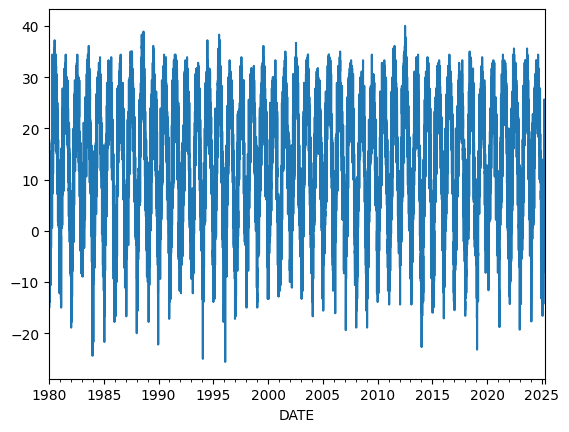

In [6]:
# Does this look reasonable?
t2m.plot()

## Data preparation

To prepare our data for training a model, we need to do the following:
1. Normalize the data --> reduce the magnitudes and get everything centered around zero
2. Split it into training / testing / and validation subsets

To normalize, we have some choices to make.  Do we want our model to try and learn the annual cycle, or focus on synoptic variability?  I'd choose the latter, so let's get an annual climatology and subtract that out.


DATE
1     -2.360870
2     -2.100000
3     -1.586957
4     -2.130435
5     -2.241304
         ...   
362    0.366667
363   -0.075556
364   -0.946667
365   -0.737778
366   -0.958333
Name: VALUE, Length: 366, dtype: float64

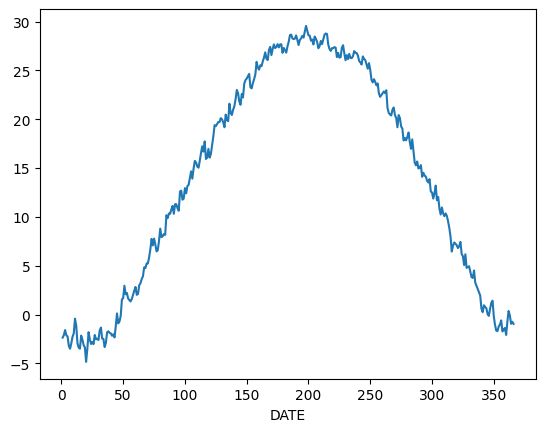

In [7]:
# Group by day of year and take the mean
doy_means = t2m.groupby(t2m.index.day_of_year).mean()
doy_means.plot()
doy_means

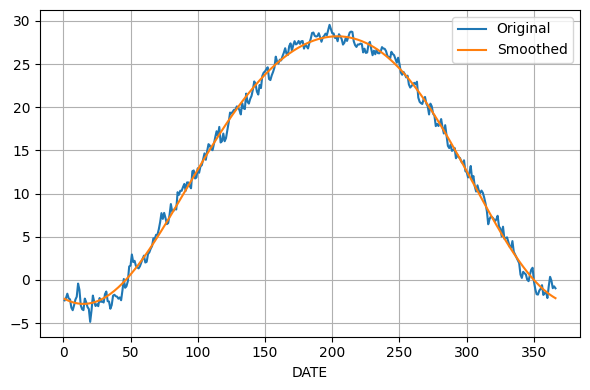

In [8]:
# Get a smooth sinusoid representation of this for the annual cycle
# Do a fast Fourier Transform
raw_fft = np.fft.fft(doy_means.values)

# Mask out everything except the first two
# modes (and the corresponding symmetric
# two modes on the other end of the complex spectrum)
truncated_fft = np.zeros_like(raw_fft)
truncated_fft[0:3] = raw_fft[0:3]
truncated_fft[-2:] = raw_fft[-2:]

# Reconstruct the signal
smooth_signal = np.fft.ifft(truncated_fft).real

# Make into a pandas series
smooth_signal = pd.Series(smooth_signal, index=doy_means.index)

# Compare
plt.figure(figsize=(6,4))
ax = plt.gca()
doy_means.plot(ax=ax, label='Original')
smooth_signal.plot(ax=ax, label='Smoothed')
plt.legend(loc=0)
plt.grid()
plt.tight_layout()
plt.show()

DATE
1980-01-01   -0.010756
1980-01-02    0.568652
1980-01-03   -2.057721
1980-01-04   -0.889905
1980-01-05    0.272075
                ...   
2025-04-08   -5.566688
2025-04-09   -3.130247
2025-04-10   -6.693146
2025-04-11   -0.255307
2025-04-12    3.883346
Name: VALUE, Length: 16539, dtype: float64

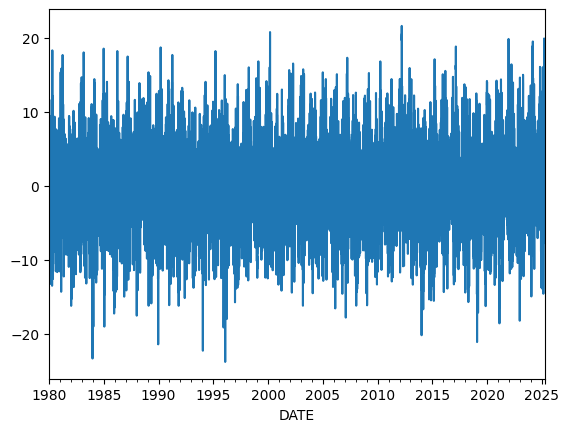

In [9]:
# Normalize the full time series by these day-of-year means
doy_norm_t2m = t2m - smooth_signal.loc[t2m.index.day_of_year].values
doy_norm_t2m.plot()
doy_norm_t2m

DATE
1980-01-01   -0.001600
1980-01-02    0.105835
1980-01-03   -0.381154
1980-01-04   -0.164614
1980-01-05    0.050843
                ...   
2025-04-08   -1.031795
2025-04-09   -0.580024
2025-04-10   -1.240666
2025-04-11   -0.046945
2025-04-12    0.720454
Name: VALUE, Length: 16539, dtype: float64

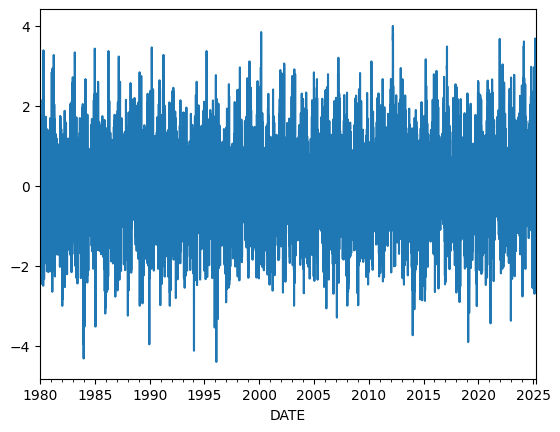

In [10]:
# Complete the normalization by subtracting the mean and dividing by 
# the standard deviation.  This puts most of the data between -4 and 4
doy_norm_t2m_mean = doy_norm_t2m.mean()
doy_norm_t2m_std = doy_norm_t2m.std()
norm_t2m = (doy_norm_t2m - doy_norm_t2m_mean) / doy_norm_t2m_std
norm_t2m.plot()
norm_t2m

In [11]:
# Split the data into training, validation, and testing periods
# Just grab groups of years for this

training_t2m = norm_t2m.loc['1980':'2015']
validation_t2m = norm_t2m.loc['2016':'2022']
testing_t2m = norm_t2m.loc['2023':]

## Building Datasets and DataLoaders

The PyTorch library has some convenient wrapper code that makes it easy for PyTorch models to understand and manipulate training datasets.  We use two concepts here:

1. A pytorch "Dataset", which defines how to get a sample of inputs and labels (expected outputs) from our data.
2. A pytorch "DataLoader" which lets you do things like sample the data in batches very easily.

In [12]:
# Use PyTorch's Dataset class to let us handle datasets nicely
class TemperatureDataset(torch.utils.data.Dataset):
    """We must define three things:
    1. An __init__ method which sets some parameters
    2. A __len__ method which determines how many samples we have
    3. A __getitem__ method which tells us how to get the input and
       target data for a given forecast.
    """
    def __init__(self, normalized_data: pd.Series, lead_time_days: int):
        """Set the following in the object so we can access them
        """
        # Make the data into a pytorch tensor
        self.normalized_data = torch.tensor(normalized_data.values, dtype=torch.float32)
        self.lead_time_days = lead_time_days

    def __len__(self):
        """Our total number of possible samples
        is then length of the normalized data, minus our lead time in days
        (we can't use the first few days since they don't have enough
        prior days to get the lead time days!)
        """
        return len(self.normalized_data) - self.lead_time_days

    def __getitem__(self, idx: int):
        """Given an index in the dataset, return both
        the correct input and target values.  Need to:
        1. Figure out what index this data is at by offseting
         by lead_time_days
        2. Return the input and target values separately
        """
        # Our inputs will be the lead_time_days prior
        # to this index
        inputs = self.normalized_data[idx:idx+lead_time_days]
        # Target is idx+lead_time_days
        target = self.normalized_data[idx+lead_time_days]

        return inputs, target

# Make datasets of each of our training, validation and testing data
lead_time_days = 4
train_ds = TemperatureDataset(normalized_data=training_t2m, lead_time_days=lead_time_days)
val_ds = TemperatureDataset(normalized_data=validation_t2m, lead_time_days=lead_time_days)
test_ds = TemperatureDataset(normalized_data=testing_t2m, lead_time_days=lead_time_days)
        

In [13]:
# Now make DataLoaders, which handle the iterative batching
# Batch size is how many samples to provide the network at
# one time to estimate gradients and update the weights
# We want to keep shuffle=False for this example so
# that time series order is preserved
batch_size = 64
shuffle = False

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=shuffle)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=shuffle)

## A Multi-Layer Perceptron model

A multi-layer perceptron model (MLP) is essentially just a stack of neurons without anything else special going on.  All the input data passes through the same linear transformations with activation functions to produce an output.  We control the number and size of all the layers and hidden states in this chain.

The code below shows how you would define this kind of model using PyTorch.

How did we decide on the depth of the model (number of layers) and the size of the hidden states?
- For this simple example, we are going to keep the model pretty shallow, with just two layers
- As for the size of the hidden states, that's...kind of a mystery.  Powers of 2 are usually used since they scale exponentially.  But it's up to you to experiment and think about, e.g., how much information might you really need to encode the possibilities you want your model to handle.

In [14]:
# In PyTorch, your model is a Python class that "inherits"
# The torch.nn.Module class
class WeatherMLP(torch.nn.Module):
    def __init__(self, lead_time_days: int):
        # When you initialize the model, initialize
        # the torch.nn.Module parent class
        super(WeatherMLP, self).__init__()

        # Model is actually defined here
        # It's a feed-forward network, so this says
        # to run these steps in sequence ("Sequential")
        self.model = torch.nn.Sequential(
            # First neuron layer --> map from
            # the number of lead time days to a 
            # hidden layer of size 64.  This makes
            # a 64 X lead_time_days array of weights
            # to learn, plus 64 biases
            torch.nn.Linear(lead_time_days, 64),
            # Apply a ReLU activation to this layer
            torch.nn.ReLU(),

            # These inputs are passed to a second
            # layer that maps from the 64 outputs
            # of layer 1 to 32 outputs of layer 2.
            # this is another 32 X 64 weight array
            # the model needs to learn, plus 32 biases
            torch.nn.Linear(64, 32),
            # And with ReLU activation again
            torch.nn.ReLU(),

            # Final layer --> Map from our 32 outputs
            # of the previous layer to a single value, 
            # which is the prediction for the next day's
            # temperature
            torch.nn.Linear(32, 1)
            # Note NO activation here!  If we applied a ReLU,
            # all our negative values would go to zero, and we'd never
            # predict anything negative!
        )
    
    def forward(self, x):
        # This defines how you run a forward pass through
        # the model, given a set of inputs x
        return self.model(x)

## Set a loss function

When we train our model, we need a way to measure how good its predictions are.  This is the **loss** that the model will try to minimize by adjusting the weights and biases.  You can write your own loss functions and make them as complicated as you want.  Several standard functions are available from PyTorch, including MeanSquaredError.  We use that here for simplicity.

In [15]:
# Use Mean Squared Error as our loss function
loss_function = torch.nn.MSELoss()

##  Training loop

This block of code initizes a clean copy of the model, sets up an "optimizer" in PyTorch that is used to adjust the weights and biases during training, and then loops through the training data several times to update the weights and biases.

Each loop through the training data is called an "epoch".  We track the value of the loss function along the way to see the model training progress.

In [16]:
# Initialize a clean copy of the model
# with our one required parameter: lead_time_days
# This sets all the weights and biases in the model to random numbers
model = WeatherMLP(lead_time_days=lead_time_days)

# The optimizer is the method to use for adjusting
# the weights during back-propagation.  We use the
# Adam optimizer here (which is pretty common)
# This is also where the "learning rate" is set:
# how far to "nudge" the weights with each back-propagation
# pass.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Put model in training mode
model.train()

# Run the training loop
# Collect the loss at the end of each pass through the training dataset
loss_collection = []

# Loop through the whole training dataset 500 times
n_epochs = 500
for epoch in range(n_epochs):
    # Use the training dataloader that we
    # made (train_loader), which will return
    # batches of inputs and targets from our dataset
    for input_batch, target_batch in train_loader:
        # Clear the weight gradients
        # from the last batch
        optimizer.zero_grad()

        # Do a forward pass through the model to make predictions
        predictions = model(input_batch)

        # Use our loss function (Mean squared error)
        # to compute our difference between the predictions
        # and our targets
        loss = loss_function(predictions.squeeze(), target_batch)

        # Run the backward pass to estimate the gradients on the weights
        loss.backward()

        # Call the optimizer to adjust the weights accordingly
        optimizer.step()

    # At the end of each epoch (loop through the training dataset)
    # save the loss
    loss_collection.append(loss.item())

    # Occasionally print progress
    if epoch % 50 == 0:
        print(f"Finished epoch: {epoch:03d} | Loss: {loss}")

Finished epoch: 000 | Loss: 0.9603176712989807
Finished epoch: 050 | Loss: 0.8383241295814514
Finished epoch: 100 | Loss: 0.8312029838562012
Finished epoch: 150 | Loss: 0.8049272298812866
Finished epoch: 200 | Loss: 0.7609493136405945
Finished epoch: 250 | Loss: 0.7306097149848938
Finished epoch: 300 | Loss: 0.7113072276115417
Finished epoch: 350 | Loss: 0.685329258441925
Finished epoch: 400 | Loss: 0.6583473086357117
Finished epoch: 450 | Loss: 0.6431505084037781


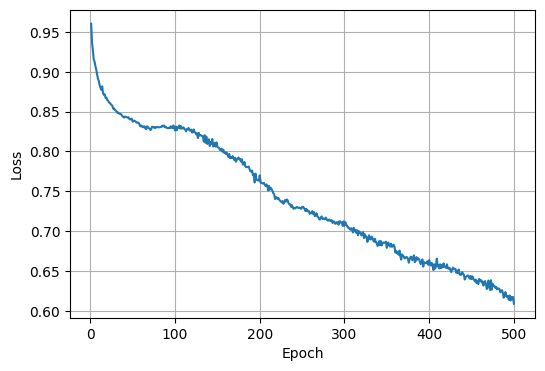

In [17]:
# Look at loss over time
plt.figure(figsize=(6,4))
epochs = np.arange(1,n_epochs+1)
plt.plot(epochs, loss_collection)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

## Validating and testing the model

Technically, you should *never* run the test data until you are completely done training the model.  But, periodically you can check against the *validation* data to see how the model is doing on some out-of-sample data and make some adjustments as needed.

Here we have a function that just does a single pass through a dataset, does not try to update any weights in the model, and just records the loss of the predictions compared to the targets.

In [18]:
def evaluate(model, dataloader, loss_function):
    # set model to evaluation mode
    model.eval()
    # Accumulate the loss across all samples
    total_loss = 0.0

    # Get all predictions and all targets as well for comparison
    all_preds = []
    all_targets = []

    # Tell Pytorch not to try and compute
    # gradients here, since we're just running
    # forward passes
    with torch.no_grad():  # no gradient computation
        for input_batch, target_batch in dataloader:
            # Make predictions
            predictions = model(input_batch).squeeze()

            # Evaluate the loss
            loss = loss_function(predictions, target_batch)
            # Scale the loss by the size of the batch
            # so we can fairly compare across batches
            total_loss += loss.item() * input_batch.size(0)

            # Keep track of our predictions and targets
            all_preds.append(predictions)
            all_targets.append(target_batch)

    # Combine all predictions and targets
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    # Compute average loss
    avg_loss = total_loss / len(dataloader.dataset)

    return avg_loss, all_preds, all_targets

In [19]:
# See if our loss numbers for these out-of-sample datasets are consistent with
# what the training loss suggests.  If they are similar, this is good: it means
# we are less likely to be over-fitting the training data.

val_loss, val_preds, val_targets = evaluate(model, val_loader, loss_function)
test_loss, test_preds, test_targets = evaluate(model, test_loader, loss_function)

print(f"Validation MSE: {val_loss:.4f}")
print(f"Test MSE: {test_loss:.4f}")

Validation MSE: 0.5794
Test MSE: 0.6343


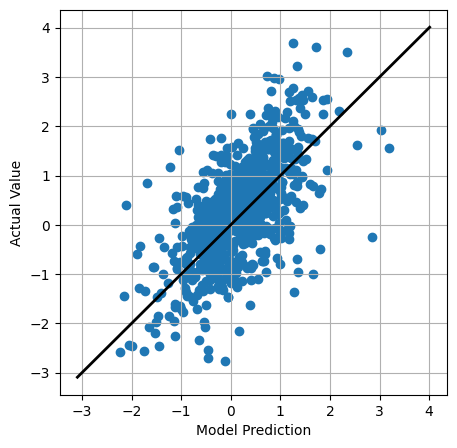

In [20]:
# How good are our predictions?

# Do a scatter plot of predictions
# versus what actually happened

plt.figure(figsize=(5,5))
# Get these out of PyTorch tensors
# and into numpy arrays
model_predictions = test_preds.numpy()
actual_values = test_targets.numpy()

plt.scatter(model_predictions, actual_values)
plt.xlabel('Model Prediction')
plt.ylabel('Actual Value')

# Do a 1-1 line
min_value = min(plt.xlim()[0], plt.ylim()[0])
max_value = max(plt.xlim()[-1], plt.ylim()[-1])
plt.plot([min_value, max_value], [min_value, max_value], c='k', lw=2)

plt.grid()
plt.show()

## Look at the model weights
The current set of weights and biases can be accessed with the `.state_dict()` attribute of the model object.

The keys tell you which "step" we are on, so to get the weights for the first layer of our MLP model, you would get the key:

`model.0.weight`

(Python indexing starts at 0, so the first step is step 0.  The activation steps are also included in the indexing even though nothing is learned there.  So the weights for the next layer of the model are index "2").

From above, `model.0.weight` is the 64 X lead_time_days weight array.

In [21]:
# The whole state dictionary
model.state_dict()

OrderedDict([('model.0.weight',
              tensor([[ 2.2749e-01, -1.3241e-01,  1.9435e-01, -3.7234e-01],
                      [ 8.3574e-02,  4.8809e-02,  3.7139e-01,  5.0260e-02],
                      [-5.3085e-01,  2.4314e-01,  2.9432e-01,  8.7145e-02],
                      [ 5.0896e-01,  2.2080e-01, -4.5123e-01, -3.8965e-01],
                      [ 1.1204e-01,  2.7938e-01, -4.0372e-02, -7.8219e-01],
                      [-1.6669e-01,  9.4754e-02, -7.9138e-01,  7.5390e-01],
                      [-2.1090e-01,  4.1022e-01, -4.1421e-01,  1.8056e-01],
                      [-1.6181e-01, -4.9291e-01, -1.3674e-01, -2.0946e-02],
                      [-3.4647e-01,  1.9094e-01, -2.2478e-01, -1.3659e-01],
                      [ 5.8989e-01, -1.6640e-01, -4.8097e-01, -2.7702e-01],
                      [ 5.1062e-02,  4.3826e-01, -6.3621e-01,  2.8609e-01],
                      [ 2.8273e-01,  3.1299e-02,  8.5756e-01,  2.5332e-01],
                      [-2.0505e-01, -6.4315e-01,  4.7286

In [22]:
model.state_dict()['model.0.weight'].shape

torch.Size([64, 4])

## Using the model in practice

Two final tasks:
1. How do we save a trained model for later use?
2. If I wanted to make a single prediction with this model, how do I do that?

In [23]:
# Saving model weights
torch.save(model.state_dict(), 'weather_model.pytorch')

In [24]:
# To load them again, we need the model object defined in code above
# so PyTorch knows what to do with these weights

# New clean copy of the model
pretrained_model = WeatherMLP(lead_time_days=lead_time_days)
# Load the weights from the file
model.load_state_dict(torch.load("weather_model.pytorch"))


<All keys matched successfully>

### Make a single prediction

In [25]:
# To make predictions, be sure we set the model to eval mode first
model.eval()

WeatherMLP(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [26]:
# Remember we need to normalize our input data first for this to work!

# Go back to our raw temperature and get the last lead_time_days values as inputs
latest_days = t2m[-lead_time_days:]
latest_days


DATE
2025-04-09     9.4
2025-04-10     6.1
2025-04-11    12.8
2025-04-12    17.2
Name: VALUE, dtype: float64

In [27]:
# Apply the normalization!
latest_days_normalized = ((latest_days - smooth_signal.loc[latest_days.index.day_of_year].values) - doy_norm_t2m_mean) / doy_norm_t2m_std
latest_days_normalized

DATE
2025-04-09   -0.580024
2025-04-10   -1.240666
2025-04-11   -0.046945
2025-04-12    0.720454
Name: VALUE, dtype: float64

In [28]:
# Convert the values to a PyTorch tensor
# Need to add a fake 1D leading dimension for a "batch" of 1
latest_days_tensor = torch.tensor(latest_days_normalized.values[None,:], dtype=torch.float32)

# Run the forward pass through the model
predicted_temp_norm = model(latest_days_tensor).item()
predicted_temp_norm

0.5745776891708374

In [29]:
# What is our next day's date?
next_day = latest_days.index[-1] + timedelta(days=1)
next_day

Timestamp('2025-04-13 00:00:00')

In [30]:
next_day.day_of_year

103

In [31]:
# Undo the normalization again!
predicted_temp = ((predicted_temp_norm * doy_norm_t2m_std) + doy_norm_t2m_mean) + smooth_signal.loc[next_day.day_of_year]
print(f"Predicted next-day max temperature: {predicted_temp:.2f}°C")

Predicted next-day max temperature: 16.67°C
